# Homework 1: Numpy, Scipy, Pandas

### Due Friday Sept 9, 2016 @ 9am


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="https://www.evernote.com/l/AUX8wzRzuFJMB53yGp1CR3ouUojjUvrR7FEB/image.png">

Name your repo something sensible (e.g. python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="https://www.evernote.com/l/AUV3Z6iVPuBN_Z6LUDZ6zBi-nmC3UQwer9gB/image.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
git clone https://github.com/profjsb/python-ay250-homework.git
cd /class/directories ## this will be different on your machine
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
```

e. To submit your work, send us (prof+GSIs) your github handle and repo name for us to clone (you'll need to add us to the repo if you've made a private one)

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="data/im2-1.png">

A tarball of the data is at: https://drive.google.com/open?id=0B4vIeCR-xYNnbXFJTTVlVnpUZkk

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint1: you'll need to figure out how to resize a numpy array
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

read in images

In [1]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt
# from scipy.signal import fftconvolve
import scipy, skimage
import numpy as np
%matplotlib inline

read images in grey scale, put in a list
<font color='red'> I followed the hints but didn't get clean image ... So I tried the following alternative method, which utilizes exiting template matching and register translation functions in skimage. For this method, resizing images naively doesn't seem to improve result further. </font>

In [2]:
img_dir = 'data/super_resolution_imaging'
images = []

for subdir, dirs, files in os.walk(img_dir):
    for file in files:
        image = imread(os.path.join(subdir, file), as_grey=True)
#         image = skimage.transform.rescale(image, 3)
        images += [image]

In [3]:
from skimage.feature import register_translation
from scipy.ndimage.interpolation import shift

In [4]:
from skimage.feature import match_template

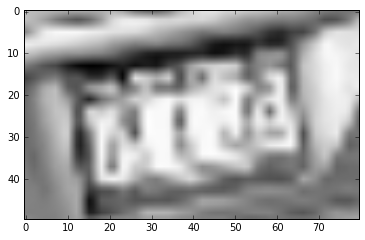

In [5]:
# crop the first image to obtain 
plate = images[0][130:180, 90:170]
plt.imshow(plate, cmap='gray')

I follow the template matching example to find the location of the plates:
    
    http://scikit-image.org/docs/dev/auto_examples/plot_template.html

In [6]:
# use the 50th image to demonstrate
ii = 50
result = match_template(images[ii], plate)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

# subimage on identified from the 50th images
# match template within one pixel
hplate, wplate = plate.shape
subimage = images[ii][y:y+hplate, x:x+wplate]

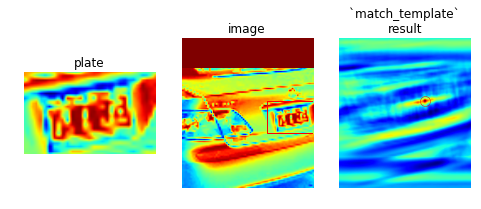

In [7]:
# plots showing the identified subimage inside the target image
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2, adjustable='box-forced')

ax1.imshow(plate)
ax1.set_axis_off()
ax1.set_title('plate')

ax2.imshow(images[ii])
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hplate, wplate = plate.shape
rect = plt.Rectangle((x, y), wplate, hplate, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [8]:
# find the sub-pixel shift up to 0.01 pixel accuracy
shift, error, diffphase = register_translation(plate, subimage, 100)
print(shift)

[ 0.39  0.31]


find subimages for all images

In [9]:
def subimage(image, template):
    """
    Find the subimage inside image that match template
    within 1 pixel
    """
    result = match_template(image, plate)
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]
    hplate, wplate = plate.shape
    subimage = image[y:y+hplate, x:x+wplate]
    return subimage
    
subimages = [subimage(image, plate) for image in images]

find the subpixel shifts for each subimage

In [10]:
from skimage.feature import register_translation

def subpixel_shift(image, template):
    """
    Find the subpixel shift between image and template.
    The shift should be within 1 pixel
    """
    shift, _, _ = register_translation(template, image, 100)
    return shift

subpixel_shifts = [subpixel_shift(subimage, plate) for subimage in subimages]

In [11]:
# print subpixel shifts for the first 10 images
np.array(subpixel_shifts[:10])

array([[ 0.  ,  0.  ],
       [-0.24, -0.17],
       [-0.22,  0.2 ],
       [ 0.01,  0.17],
       [-0.17,  0.04],
       [-0.31, -0.14],
       [-0.2 ,  0.25],
       [ 0.02,  0.31],
       [ 0.1 ,  0.14],
       [-0.19, -0.2 ]])

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

In [12]:
from scipy.ndimage.interpolation import shift

In [13]:
shifted_subimages = []
for i, image in enumerate(subimages):
    shifted_subimage = scipy.ndimage.shift(image, subpixel_shifts[i])
    shifted_subimages += [shifted_subimage]

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

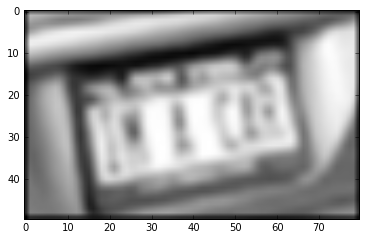

In [14]:
combined_subimage = np.array(shifted_subimages).mean(axis=0)
plt.imshow(combined_subimage, cmap='gray')

<font color='red'> The combined image is still not very clear. But it's probably '1M A CAZ'</font>

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

Populating the interactive namespace from numpy and matplotlib


We define a simple utility function to listen to audio files right in the browser:

In [2]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [3]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `hw_0_data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [4]:
# your code here
fname = 'data/audio_compression/voice.wav'
Audio(fname)

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [5]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    # your code here
    
    fft_x = np.fft.rfft(x)
    n = len(fft_x)
    n_zeros = int(fraction * n)
    fft_x[np.argsort(fft_x)[0:n_zeros]] = 0
    return np.fft.irfft(fft_x)

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [6]:
x = np.random.rand(128)

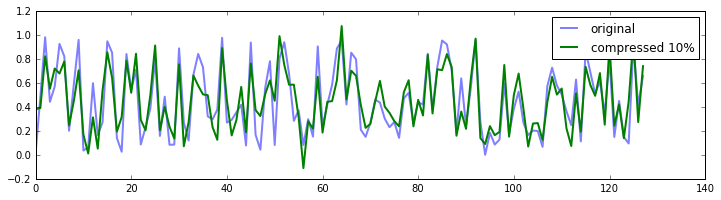

In [7]:
fraction = 0.1  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [9]:
import scipy.io.wavfile
import os

In [10]:
fname = 'data/audio_compression/voice.wav'

In [11]:
def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    # your code here
    rate, x = scipy.io.wavfile.read(fname)
    x_approx = compress_signal(x, fraction)
    dir_name = os.path.dirname(fname)
    file_base= os.path.basename(fname).split('.')[0] + '_comp_' + '{}'.format(fraction) +'.wav'
    new_fname = dir_name + '/' + file_base
    scipy.io.wavfile.write(new_fname, rate, x_approx)
    return rate, x, x_approx, new_fname

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](http://docs.python.org/2/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [12]:
# your code here
from collections import OrderedDict

In [13]:
voices = OrderedDict()

In [19]:
fractions = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99]
fname = 'data/audio_compression/voice.wav'
for fraction in fractions:
    _, _, x_approx, new_fname = compress_wav(fname, fraction)
    voices.update({fraction: (x_approx, new_fname)})

**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

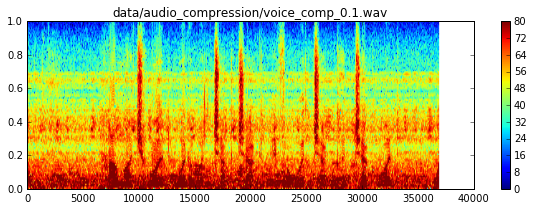

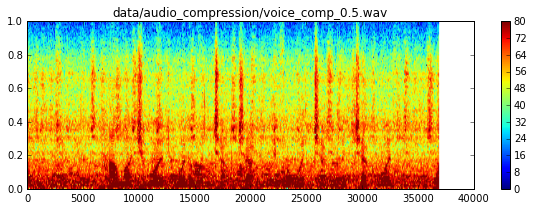

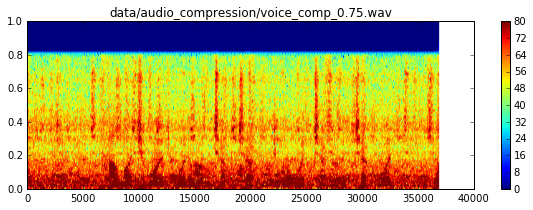

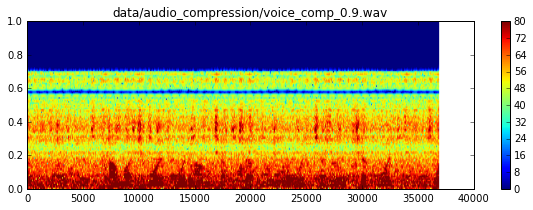

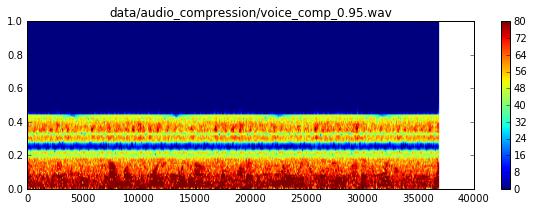

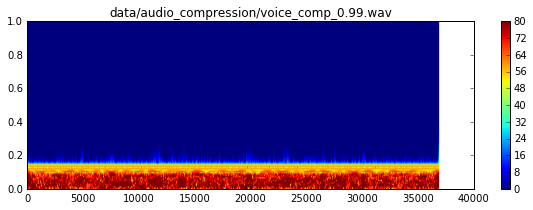

In [24]:
# your code here
for key, val in voices.items():
    x_approx, new_fname = val
    Audio(new_fname)
    title = new_fname
    specgram_cbar(x_approx, title=title, clim=(0, 80) )

In [28]:
<font color='red'> I stopped to understand recording when fraction > 0.5 '1M A CAZ'</font>

SyntaxError: invalid syntax (<ipython-input-28-ab09982f448b>, line 1)

# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle`

In [ ]:
# your code here

# #4: Reproducing some insights about the Election

Nate ("not a genius, just a Bayesian") Silver writes often about polls and their utility of predicting elections. One of the things he emphasized during the 2016 campaign is that even "large" polls of people with a consistent lead for one candidate will show wild swings in any given window in time.

**Problem 1**: Using Pandas and `numpy`, try to reproduce this plot from a Nate Silve Tweet qualitatively using the same assumptions.

<img src="https://www.evernote.com/l/AUU-KkH3Z-lBdKokzCzVIUe53YZLQ9e_AuMB/image.png">

https://twitter.com/NateSilver538/status/769565612955824128

In [ ]:
# your code here

**Problem 2**: Clearly, even with a 6% point lead, there's a chance that this sort of poll would show the other person in the lead. How much would ahead (in percent) would a candidate need to be to have a tracking poll never show the other candidate to be ahead over the course of a year (in your simulation)?

In [ ]:
# your code here

**Problem 3**: With a 3 and 6% lead, how many people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead (over a year)?

In [ ]:
# your code here